In [1]:
from pathlib import Path
import pandas as pd
import json
import allantools
import numpy as np

In [6]:
data_folder = Path("src")
file_to_open = "drift_test_dont_touch.log"

In [21]:
data = []
with open(file_to_open) as file:
    for line in file:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            print('Skipped line.')

df = pd.DataFrame(data)
df

,start_time,LW_dis,RW_dis,LW_total,RW_total,unix_timestamp,x_loc,y_loc,heading,LSensor,RSensor,reset
0,1421.174516,0.0,0.0,0.0,0.0,1.699655e+09,0.0,0.0,0,"{'accX': -0.01348876953125, 'accY': -0.0045166...","{'accX': -0.0174560546875, 'accY': -0.01788330...",False
1,1421.174516,0.0,0.0,0.0,0.0,1.699655e+09,0.0,0.0,0,"{'accX': -0.013671875, 'accY': -0.004455566406...","{'accX': -0.017333984375, 'accY': -0.017761230...",False
2,1421.174516,0.0,0.0,0.0,0.0,1.699655e+09,0.0,0.0,0,"{'accX': -0.0135498046875, 'accY': -0.00488281...","{'accX': -0.01715087890625, 'accY': -0.0175170...",False
3,1421.174516,0.0,0.0,0.0,0.0,1.699655e+09,0.0,0.0,0,"{'accX': -0.0140380859375, 'accY': -0.00433349...","{'accX': -0.01739501953125, 'accY': -0.0181274...",False
4,1421.174516,0.0,0.0,0.0,0.0,1.699655e+09,0.0,0.0,0,"{'accX': -0.0147705078125, 'accY': -0.00439453...","{'accX': -0.0169677734375, 'accY': -0.01763916...",False
...,...,...,...,...,...,...,...,...,...,...,...,...
90183,1421.174516,0.0,0.0,0.0,0.0,1.699658e+09,0.0,0.0,0,"{'accX': -0.01239013671875, 'accY': -0.0043945...","{'accX': -0.01568603515625, 'accY': -0.0180664...",False
90184,1421.174516,0.0,0.0,0.0,0.0,1.699658e+09,0.0,0.0,0,"{'accX': -0.0133056640625, 'accY': -0.00494384...","{'accX': -0.01544189453125, 'accY': -0.0179443...",False
90185,1421.174516,0.0,0.0,0.0,0.0,1.699658e+09,0.0,0.0,0,"{'accX': -0.01312255859375, 'accY': -0.0045776...","{'accX': -0.0152587890625, 'accY': -0.01763916...",False
90186,1421.174516,0.0,0.0,0.0,0.0,1.699658e+09,0.0,0.0,0,"{'accX': -0.0128173828125, 'accY': -0.00506591...","{'accX': -0.01513671875, 'accY': -0.0180664062...",False


In [18]:
left_sensor = df['LSensor'].apply(
    lambda x: pd.Series([x['timestamp'], x['gyroX'], x['gyroY'], x['gyroZ']],
                         index=['timestamp', 'gyroX', 'gyroY', 'gyroZ'])
)

right_sensor = df['RSensor'].apply(
    lambda x: pd.Series([x['timestamp'], x['gyroX'], x['gyroY'], x['gyroZ']], 
                        index=['timestamp', 'gyroX', 'gyroY', 'gyroZ'])
)

fs = 25.0 # Hz
ts = 1.0 / fs

# Convert to degree/s
l_timestamp = left_sensor[['timestamp']].to_numpy()
l_gyroX = left_sensor[['gyroX']].to_numpy() * (180.0 / np.pi)
l_gyroY = left_sensor[['gyroY']].to_numpy() * (180.0 / np.pi)
l_gyroZ = left_sensor[['gyroZ']].to_numpy() * (180.0 / np.pi)

l_thetaX = np.cumsum(l_gyroX) * ts
l_thetaY = np.cumsum(l_gyroY) * ts
l_thetaZ = np.cumsum(l_gyroZ) * ts

r_gyroX = right_sensor[['gyroX']].to_numpy() * (180.0 / np.pi)
r_gyroY = right_sensor[['gyroY']].to_numpy() * (180.0 / np.pi)
r_gyroZ = right_sensor[['gyroZ']].to_numpy() * (180.0 / np.pi)

r_thetaX = np.cumsum(r_gyroX) * ts
r_thetaY = np.cumsum(r_gyroY) * ts
r_thetaZ = np.cumsum(r_gyroZ) * ts

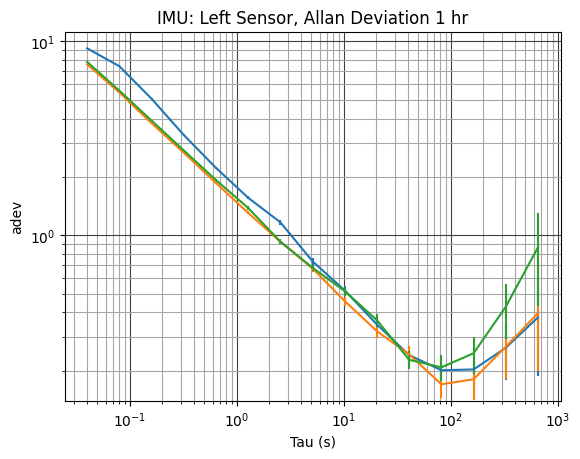

In [19]:
a = allantools.Dataset(data=l_thetaX, rate=fs)
a.compute("adev")

b = allantools.Dataset(data=l_thetaY, rate=fs)
b.compute("adev")

c = allantools.Dataset(data=l_thetaZ, rate=fs)
c.compute("adev")


p = allantools.Plot()
p.plot(a, errorbars=True, grid=True)
p.plot(b, errorbars=True, grid=True)
p.plot(c, errorbars=True, grid=True)
p.ax.set_xlabel("Tau (s)")
p.ax.set_title("IMU: Left Sensor, Allan Deviation 1 hr")
p.show()

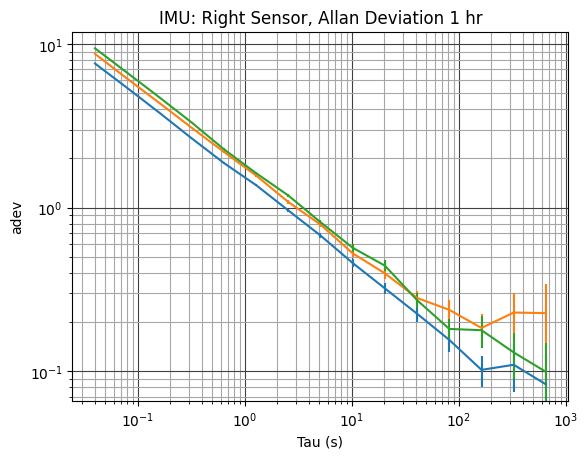

In [20]:
a = allantools.Dataset(data=r_thetaX, rate=fs)
a.compute("adev")

b = allantools.Dataset(data=r_thetaY, rate=fs)
b.compute("adev")

c = allantools.Dataset(data=r_thetaZ, rate=fs)
c.compute("adev")


p = allantools.Plot()
p.plot(a, errorbars=True, grid=True)
p.plot(b, errorbars=True, grid=True)
p.plot(c, errorbars=True, grid=True)
p.ax.set_xlabel("Tau (s)")
p.ax.set_title("IMU: Right Sensor, Allan Deviation 1 hr")
p.show()